<a href="https://colab.research.google.com/github/LEEINSEO-0118/Seed_Weight_Predict/blob/main/seed_weight_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import seaborn as sns
from tqdm import tqdm
import re

# Information

Data
* 400 - (349 nonnull, 51 null)
* Seed Length (long, short)
* Seed weight
* Leaf Length (long, short)

# Preprocessing

* 종자 장 + 단 길이 생성
* 초엽 크기 단위 mm 변경 및 길이1 + 길이2 생성
* 초엽 크기 0 (null)값 제거 -> 이용 가능한 데이터 : 349

In [3]:
# data load
path = f'/content/drive/MyDrive/졸업논문/data/numeric_data/data.xlsx'
data = pd.read_excel(path)
display(data.info())
data.replace(0, np.nan, inplace=True) # 0인 값을 null로 변환

# feature combination
# data.leaf_1 = data.leaf_1 * 10 # cm to mm
# data.leaf_2 = data.leaf_2 * 10
data['leaf_length_sum'] = data.leaf_1 + data.leaf_2
data = data.drop(data.columns[:4], axis = 1)
data = data.dropna()

# # delete null row
# data = data[data.leaf_length_sum != 0]

# add leaf area
data['leaf_area'] = data.leaf_1 * data.leaf_2

# add leaf div
data['leaf_div_1'] = abs(data.leaf_1 / data.leaf_2)
data['leaf_div_2'] = abs(data.leaf_2 / data.leaf_1)

display(data.head())
display(data.info())

print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  400 non-null    int64  
 1   tray_num    400 non-null    int64  
 2   KNU         400 non-null    int64  
 3   name        400 non-null    object 
 4   weight      400 non-null    float64
 5   seed_long   400 non-null    float64
 6   seed_short  400 non-null    float64
 7   leaf_1      400 non-null    float64
 8   leaf_2      400 non-null    float64
dtypes: float64(5), int64(3), object(1)
memory usage: 28.2+ KB


None

,weight,seed_long,seed_short,leaf_1,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2
0,0.17,7.976471,7.341176,5.0,4.3,9.3,21.50,1.162791,0.860000
1,0.19,7.844192,7.419240,4.0,3.4,7.4,13.60,1.176471,0.850000
2,0.16,8.841370,7.052203,5.5,4.4,9.9,24.20,1.250000,0.800000
4,0.21,8.058351,7.868689,6.5,5.9,12.4,38.35,1.101695,0.907692
5,0.19,8.435368,8.185801,6.0,4.6,10.6,27.60,1.304348,0.766667


<class 'pandas.core.frame.DataFrame'>
Index: 349 entries, 0 to 399
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   weight           349 non-null    float64
 1   seed_long        349 non-null    float64
 2   seed_short       349 non-null    float64
 3   leaf_1           349 non-null    float64
 4   leaf_2           349 non-null    float64
 5   leaf_length_sum  349 non-null    float64
 6   leaf_area        349 non-null    float64
 7   leaf_div_1       349 non-null    float64
 8   leaf_div_2       349 non-null    float64
dtypes: float64(9)
memory usage: 27.3 KB


None

weight             0
seed_long          0
seed_short         0
leaf_1             0
leaf_2             0
leaf_length_sum    0
leaf_area          0
leaf_div_1         0
leaf_div_2         0
dtype: int64


# EDA

Non null data count = 349

In [4]:
# 수치형 데이터들의 상관관계 파악
# 종자 무게와 - 잎 크기 데이터와의 상관관계만 사용
numeric = ['weight', 'leaf_1', 'leaf_2', 'leaf_length_sum', 'leaf_area', 'leaf_div_1', 'leaf_div_2']
data_num = data[numeric]
display(data_num.corr())
print(data_num.isnull().sum())

,weight,leaf_1,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2
weight,1.000000,0.226299,0.551411,0.414213,0.461696,-0.477684,0.475763
leaf_1,0.226299,1.000000,0.728638,0.933016,0.890807,0.242277,-0.289992
leaf_2,0.551411,0.728638,1.000000,0.926282,0.946257,-0.467639,0.416407
leaf_length_sum,0.414213,0.933016,0.926282,1.000000,0.987271,-0.112390,0.059220
leaf_area,0.461696,0.890807,0.946257,0.987271,1.000000,-0.189683,0.137583
leaf_div_1,-0.477684,0.242277,-0.467639,-0.112390,-0.189683,1.000000,-0.971315
leaf_div_2,0.475763,-0.289992,0.416407,0.059220,0.137583,-0.971315,1.000000


weight             0
leaf_1             0
leaf_2             0
leaf_length_sum    0
leaf_area          0
leaf_div_1         0
leaf_div_2         0
dtype: int64


## Distribution

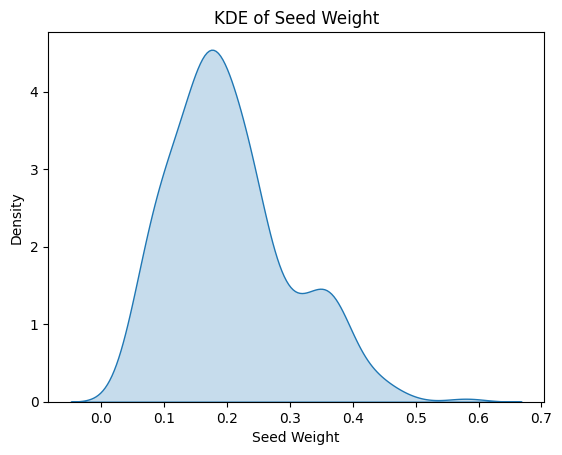

In [5]:
# KDE 플롯 그리기
sns.kdeplot(data_num.weight, fill=True)
plt.title('KDE of Seed Weight')
plt.xlabel('Seed Weight')
plt.ylabel('Density')
plt.show()

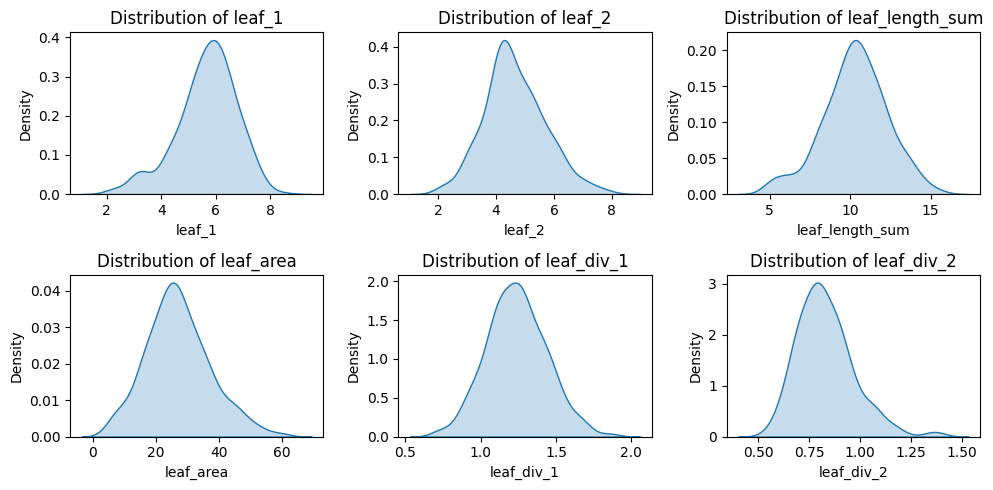

In [6]:
# 플롯 설정
fig, axes = plt.subplots(2, 3, figsize=(10, 5))  # 2행 3열의 서브플롯 생성
axes = axes.flatten()  # 2D 배열을 1D로 변환

# KDE 플롯 그리기
variables = data_num.columns[1:]
for i, var in enumerate(variables):
    if var in data.select_dtypes(include=['float64', 'int']).columns:  # 연속형 변수만 선택
        sns.kdeplot(data[var], ax=axes[i], fill=True)
        axes[i].set_title(f'Distribution of {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Density')

# 레이아웃 조정
plt.tight_layout()
plt.show()

## Target 로그변환시 분포

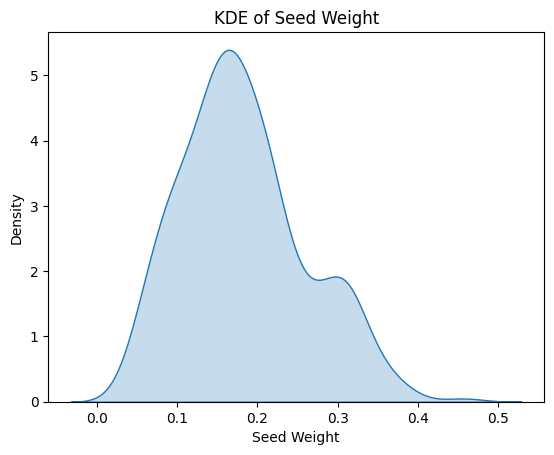

In [7]:
# KDE 플롯 그리기
weight_log = np.log1p(data_num.weight)
sns.kdeplot(weight_log, fill=True)
plt.title('KDE of Seed Weight')
plt.xlabel('Seed Weight')
plt.ylabel('Density')
plt.show()

## correlation heatmap

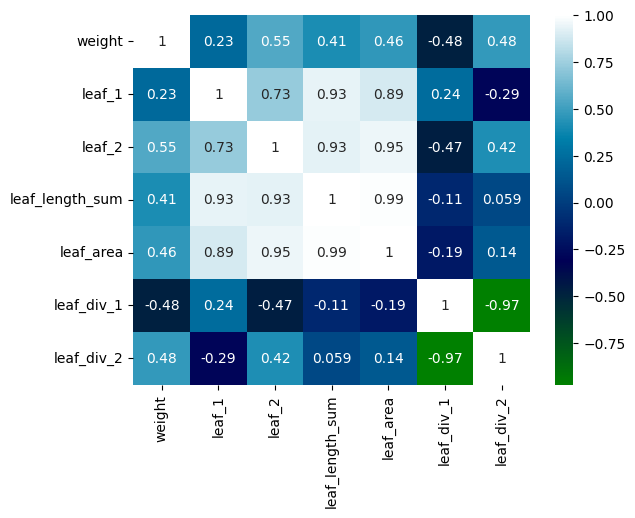

In [8]:
sns.heatmap(data_num.corr(), annot = True, cmap = 'ocean')
plt.show()

종자 무게와 잎 크기 간의 상관관계가 생각보다 작았음 -> 0.41

## 무게와 - 잎 가로, 잎 세로, 잎 가로세로 합, 잎 넓이의 산점도를 통한 데이터 분포 확인

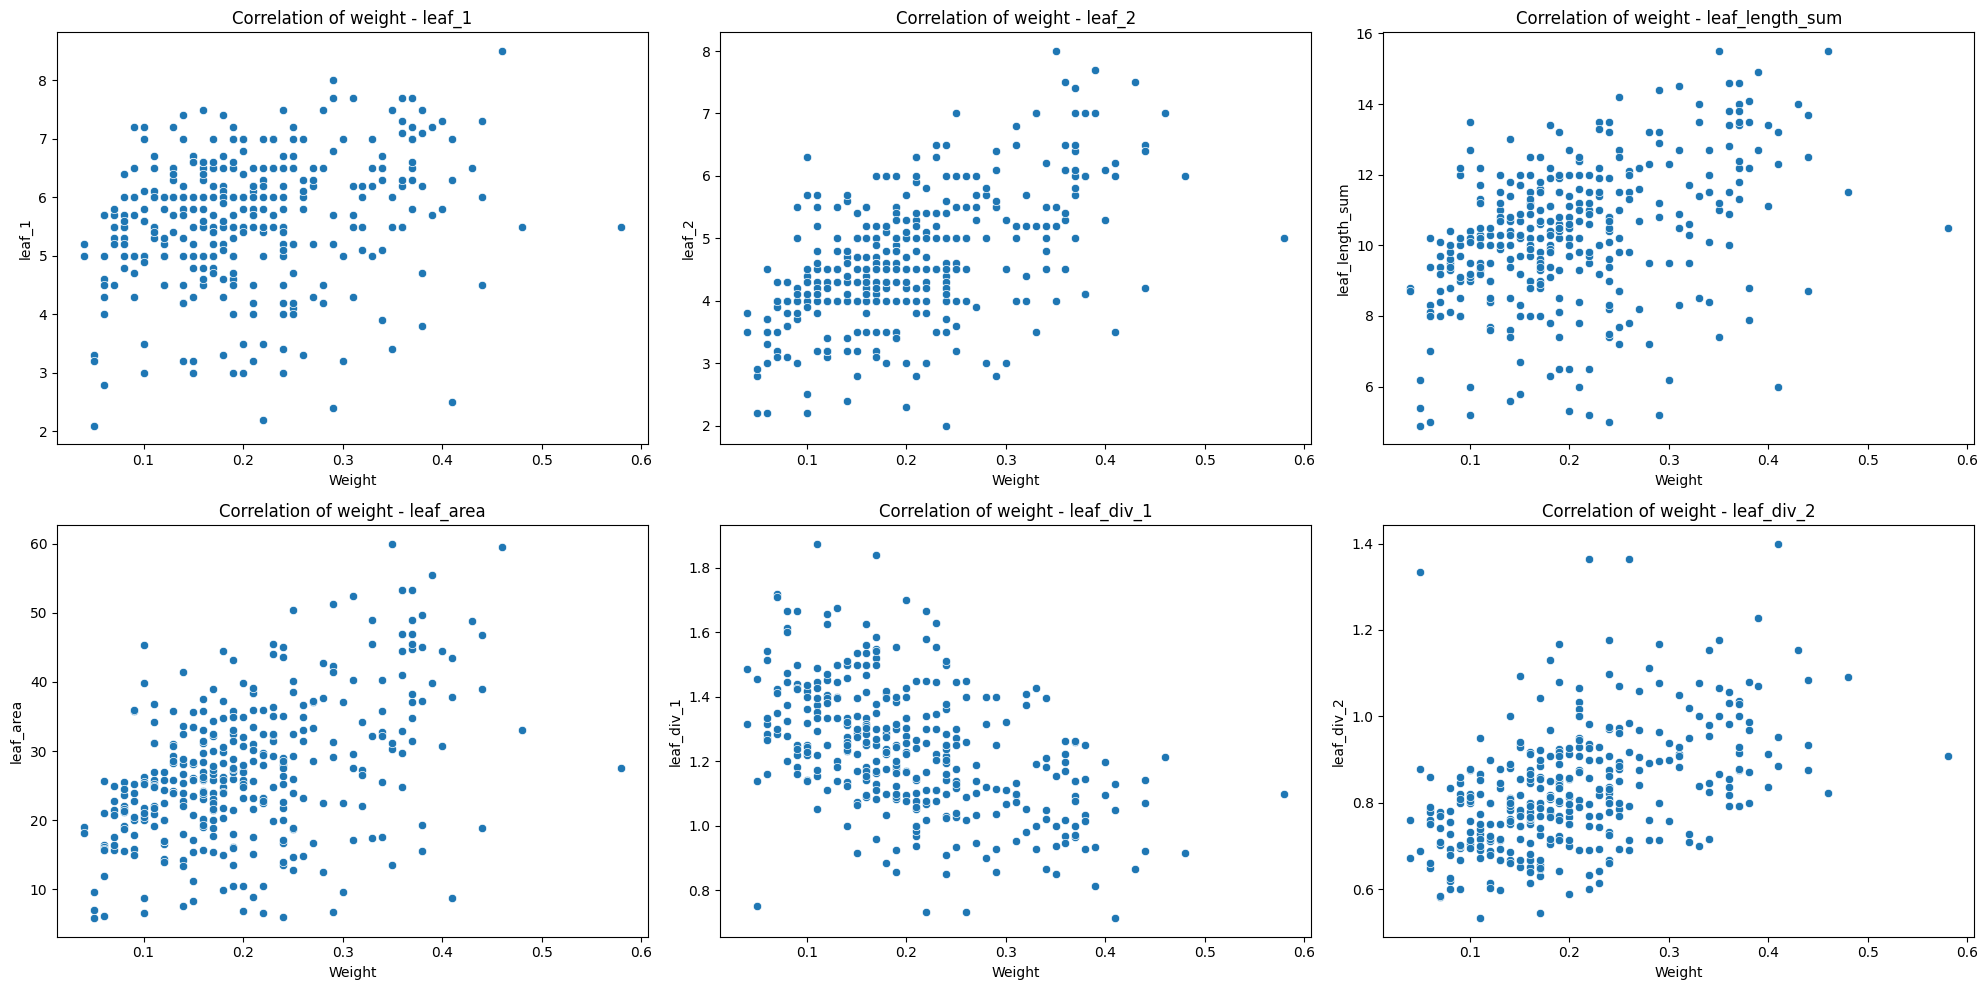

In [9]:
# 플롯 설정
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2행 3열의 서브플롯 생성
axes = axes.flatten()  # 2D 배열을 1D로 변환

# scatter 플롯 그리기
variables = data_num.columns[1:]  # 첫 번째 열 제외
for i, var in enumerate(variables):
    sns.scatterplot(data=data_num, x='weight', y=var, ax=axes[i])  # ax 매개변수 추가
    axes[i].set_title(f'Correlation of weight - {var}')
    axes[i].set_xlabel('Weight')  # x축 레이블 수정
    axes[i].set_ylabel(var)  # y축 레이블 수정

# 레이아웃 조정
plt.tight_layout()
plt.show()

- 팟을 관찰 했을 때 다른 잎에 가려지는 등 환경의 요인으로 잎이 정상적으로 생장하지 못한 것들이 있었다.
- 그래서 잎의 크기 중 이상치라고 판단되는 것들을 제거 하기로 결정


* leaf_length_sum을 기준으로 하여 threshold를 설정해 해당 값 보다 크기가 작은 데이터를 삭제하면 상관계수가 상승할 것으로 보임  
* 주변 환경으로 인해서 생육이 덜 되어, 데이터 분석에 방해가 되는 데이터를 제거하는 행위

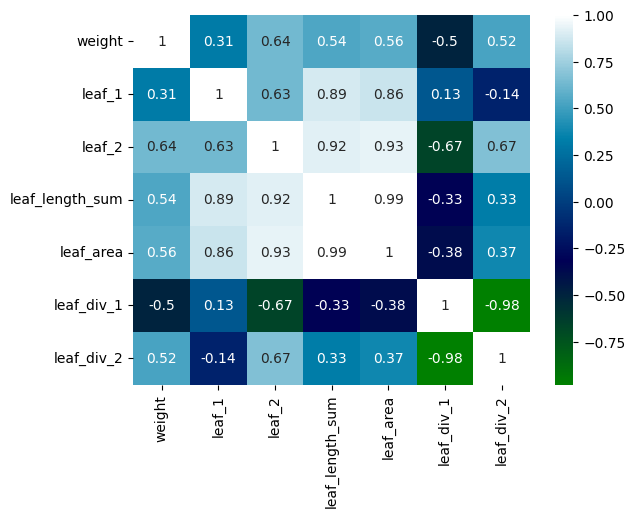

In [10]:
# 확정된 전처리
data_filtered = data_num[(data_num.leaf_length_sum >= 8)]     # 잎 길이 합이 8이상인 것 남김, null도 살림
data_filtered = data_filtered[data_filtered.weight <= 0.5] # 잎 넓이를 보았을 때, 무게 0.5 이상인 것들의 잎 넓이가 이상치로 판단됨

# 확인 중인 전처리
# data_filtered = data_filtered[data_filtered.leaf_div_2 <= 1.25] # leaf_div_2 기준으로 해당 값이 1.25 이상인 값을 제거

sns.heatmap(data_filtered.corr(), annot = True, cmap = 'ocean')
plt.show()

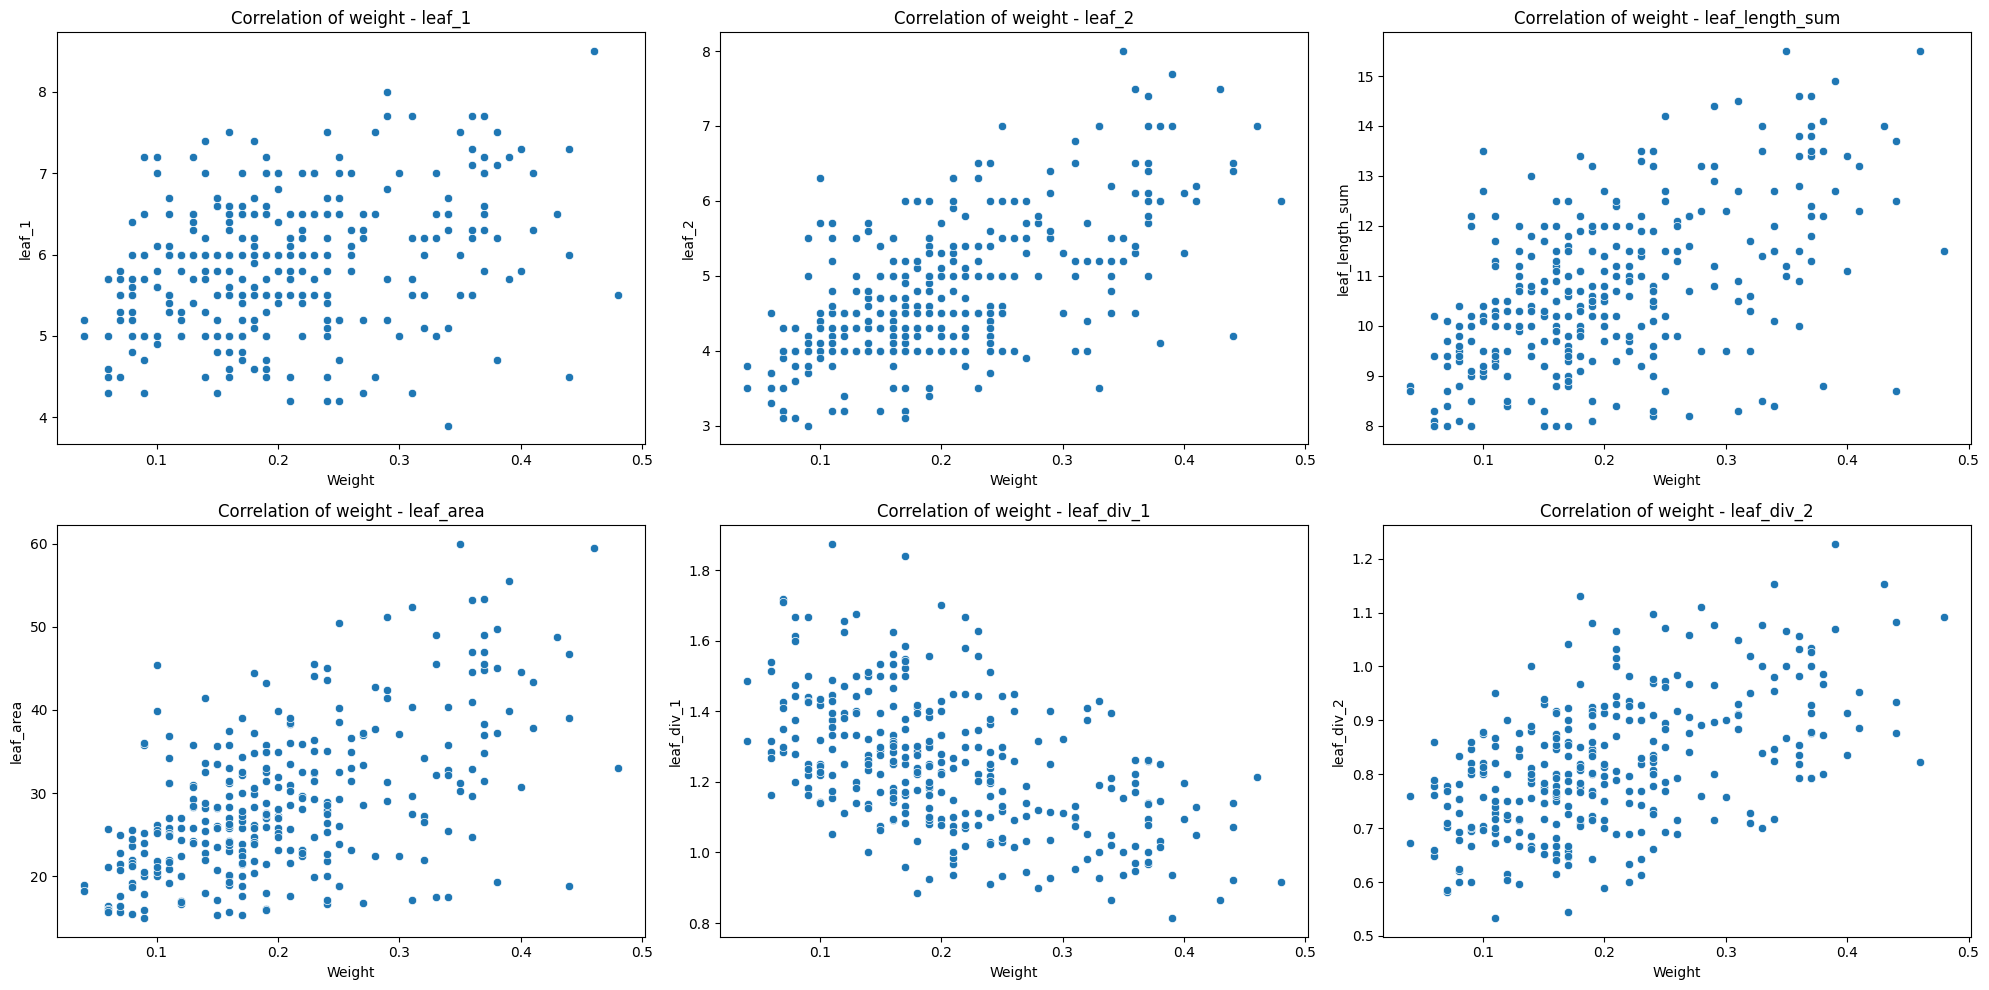

In [11]:
# 플롯 설정
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2행 3열의 서브플롯 생성
axes = axes.flatten()  # 2D 배열을 1D로 변환

# scatter 플롯 그리기
variables = data_num.columns[1:]  # 첫 번째 열 제외
for i, var in enumerate(variables):
    sns.scatterplot(data=data_filtered, x='weight', y=var, ax=axes[i])  # ax 매개변수 추가
    axes[i].set_title(f'Correlation of weight - {var}')
    axes[i].set_xlabel('Weight')  # x축 레이블 수정
    axes[i].set_ylabel(var)  # y축 레이블 수정

# 레이아웃 조정
plt.tight_layout()
plt.show()

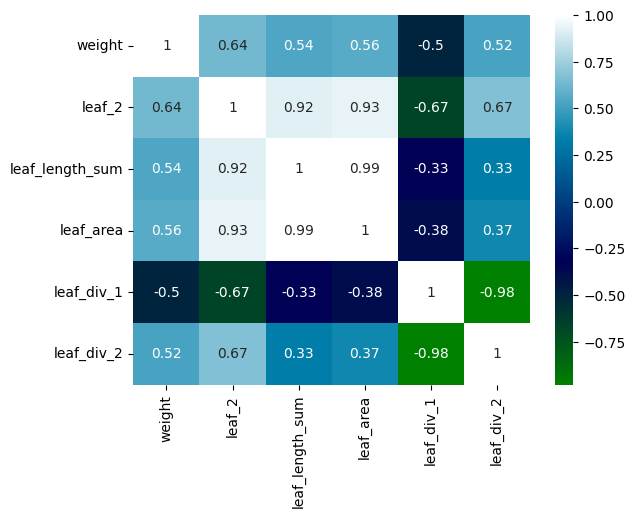

In [12]:
#### 상관관계가 약한 피쳐 제거
data_filtered = data_filtered.drop(['leaf_1'], axis = 1)

#### 다중공선성 제거
# data_filtered = data_filtered.drop(['leaf_div_1'], axis = 1)
# data_filtered = data_filtered.drop(['leaf_area'], axis = 1)
# data_filtered = data_filtered.drop(['leaf_2'], axis = 1)


sns.heatmap(data_filtered.corr(), annot = True, cmap = 'ocean')
plt.show()

# Modeling

## Origin data - Test data Compare Plot

In [13]:
def origin_test_scatter(origin, pred):
    val = pd.DataFrame({'val_answer': origin, 'pred' : pred})
    sns.set_theme(rc={'figure.figsize':(15,8)})
    sns.scatterplot(data = val, x = 'val_answer', y = 'pred', color='blue', alpha=0.6)
    sns.lineplot(x=[val['val_answer'].min(), val['val_answer'].max()],
                y=[val['val_answer'].min(), val['val_answer'].max()],
                color='red', linestyle='--')
    plt.xlabel('Validation Origin Data')
    plt.ylabel('Predicted Weight')
    plt.title("Weight Predict")
    plt.show()

## KNN Augmentation

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

# def knn_augmentation(df, n_neighbors=5, n_augmented=50, random_state=2024):
#     """
#     KNN 기반 데이터 증강 함수

#     Parameters:
#     - df (pd.DataFrame): 원본 데이터프레임
#     - n_neighbors (int): 각 데이터 포인트에 대해 찾을 이웃의 수
#     - n_augmented (int): 생성할 합성 데이터 포인트의 수
#     - random_state (int): 랜덤 시드

#     Returns:
#     - pd.DataFrame: 증강된 데이터프레임
#     """
#     np.random.seed(random_state)

#     # 입력 피처와 타겟 분리
#     X = df.drop('weight', axis=1).values
#     y = df['weight'].values.reshape(-1, 1)

#     # NearestNeighbors 모델 학습
#     nbrs = KNeighborsRegressor(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean', weights='distance', n_jobs=-1).fit(X, y)

#     augmented_X = []
#     augmented_y = []

#     for _ in range(n_augmented):
#         # 랜덤하게 베이스 포인트 선택
#         idx = np.random.randint(0, X.shape[0])
#         base_X = X[idx]
#         base_y = y[idx]

#         # 베이스 포인트의 이웃 인덱스 찾기
#         neighbor_idxs = nbrs.kneighbors([base_X], return_distance=False)[0]

#         # 이웃 중 하나를 랜덤하게 선택
#         neighbor_idx = np.random.choice(neighbor_idxs)
#         neighbor_X = X[neighbor_idx]
#         neighbor_y = y[neighbor_idx]

#         # 새로운 샘플 생성 (선형 보간)
#         lambda_val = np.random.rand()
#         new_X = base_X + lambda_val * (neighbor_X - base_X)
#         new_y = base_y + lambda_val * (neighbor_y - base_y)


#         augmented_X.append(new_X)
#         augmented_y.append(new_y)

#     # 증강된 데이터프레임 생성
#     df_augmented = pd.DataFrame(augmented_X, columns=df.columns[1:])
#     df_augmented['weight'] = np.array(augmented_y).flatten()

#     # 원본 데이터와 증강된 데이터 결합
#     df_combined = pd.concat([df, df_augmented], ignore_index=True)

#     return df_combined

## KNN Imputer

In [ ]:
# def knn_augmentation(train, valid, test):
#     # create imputer
#     knn_imputer = KNNImputer(n_neighbors=5)

#     # 훈련 데이터에 대해 KNN으로 null 값 대체
#     x_train_imputed = knn_imputer.fit_transform(train)

#     # 검증 데이터에 대해 KNN으로 null 값 대체
#     x_val_imputed = knn_imputer.transform(valid)

#     # 테스트 데이터에 대해 KNN으로 null 값 대체
#     test_imputed = knn_imputer.transform(test)

#     return x_train_imputed, x_val_imputed, test_imputed

## Modelig import

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

## Data Split

In [15]:
##### get data
data_for_model = data_filtered

##### train, test split from "total data"
train, test = train_test_split(data_for_model, test_size = 0.2, random_state = 2024)
print('train-test shape : ', train.shape, test.shape)

##### get targets from train, test
target = train.pop('weight')
answer = test.pop('weight')



########## train data augmentation ##########
# print('########## KNN Augmentation ##########')
# train = knn_augmentation(train, n_neighbors=3, n_augmented=50, random_state=2024)
# print('train-test shape After augmentation : ', train.shape, test.shape)
# display(train.corr())



##### split train, validation
x_train, x_val, y_train, y_val = train_test_split(train, target, test_size = 0.2, random_state = 2024)
print('train-valid shape : ', x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print('test shape : ', test.shape, answer.shape)


##### 로그변환
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
answer = np.log1p(answer)

# x_train = np.log1p(x_train) # x값은 로그변환해도 큰 의미 없었음, 데이터에 큰 왜도가 있는 것은 아니기도 하고, 전처리를 통해서 이상치들을 걸러내서 그런듯
# x_val = np.log1p(x_val)
# test = np.log1p(test)

##### Data scaling
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
test = scaler.transform(test)

##### Imputation
# x_train, x_val, test = knn_augmentation(x_train, x_val, test)
# print('train-valid shape After augmentation : ', x_train.shape, x_val.shape, test.shape)



# print(f'null값 제거 확인 {np.sum(np.isnan(x_train))}')

train-test shape :  (249, 6) (63, 6)
train-valid shape :  (199, 5) (199,) (50, 5) (50,)
test shape :  (63, 5) (63,)


## Human Search Modeling (RF)

In [16]:
models = []

Human Search Validation MAE :  0.0463
Human Search Validation MAPE :  29.4060%


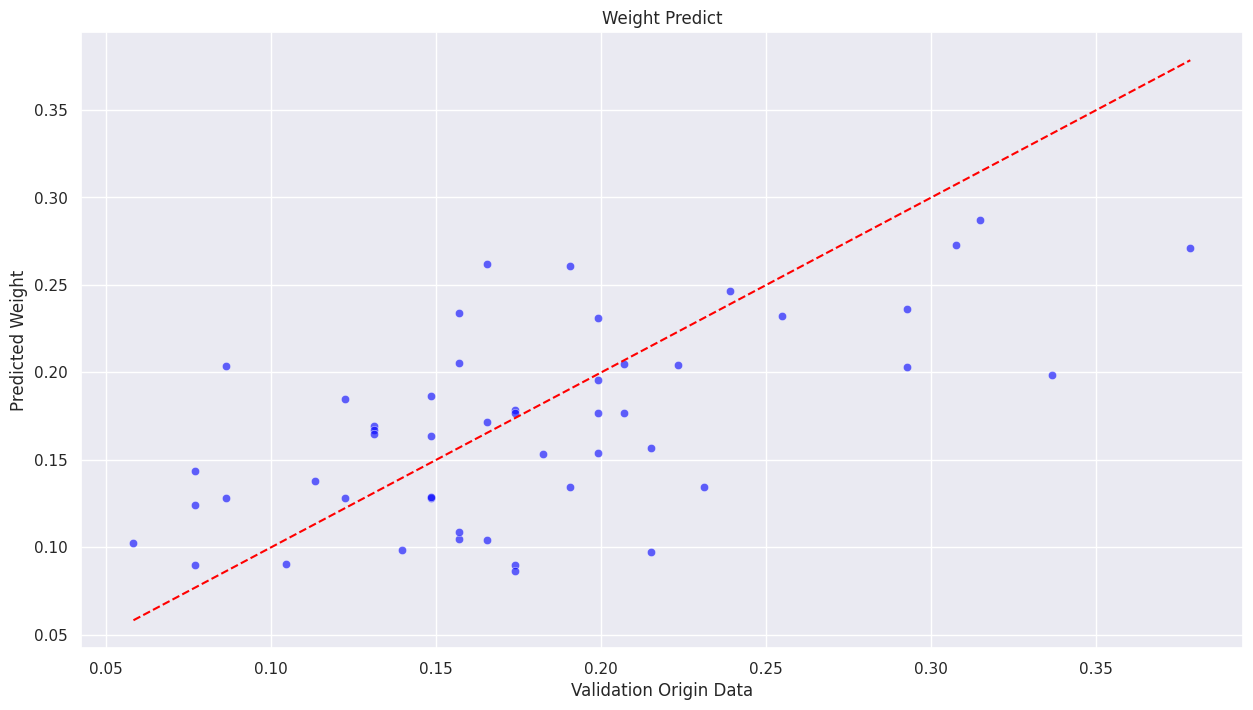

In [17]:
# modeling
#
params = {
    'random_state' : 2024,
    # CART 관련
    'min_samples_leaf' : 3, # leaf노드의 최소 샘플 수
    'max_depth' : 5, # 트리의 최대 깊이
    'max_features' : 0.5, # feature sampling 비율
    'criterion' : 'absolute_error', # 분할 척도
    # Tree Ensemble 관련
    'n_estimators' : 100, # 앙상블 트리 수
    'n_jobs' : -1, # 계산 cpu 수
}

model = RandomForestRegressor(**params)
model.fit(x_train, y_train)
pred_val = model.predict(x_val)
# 앙상블을 위한 모델 저장
models.append(model)

val_mae = mean_absolute_error(y_val, pred_val)
print(f'Human Search Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Human Search Validation MAPE : {val_mape * 100 : .4f}%')
origin_test_scatter(y_val, pred_val)

## Human Search Modeling (ER)

Human Search Validation MAE :  0.0450
Human Search Validation MAPE :  28.6790%


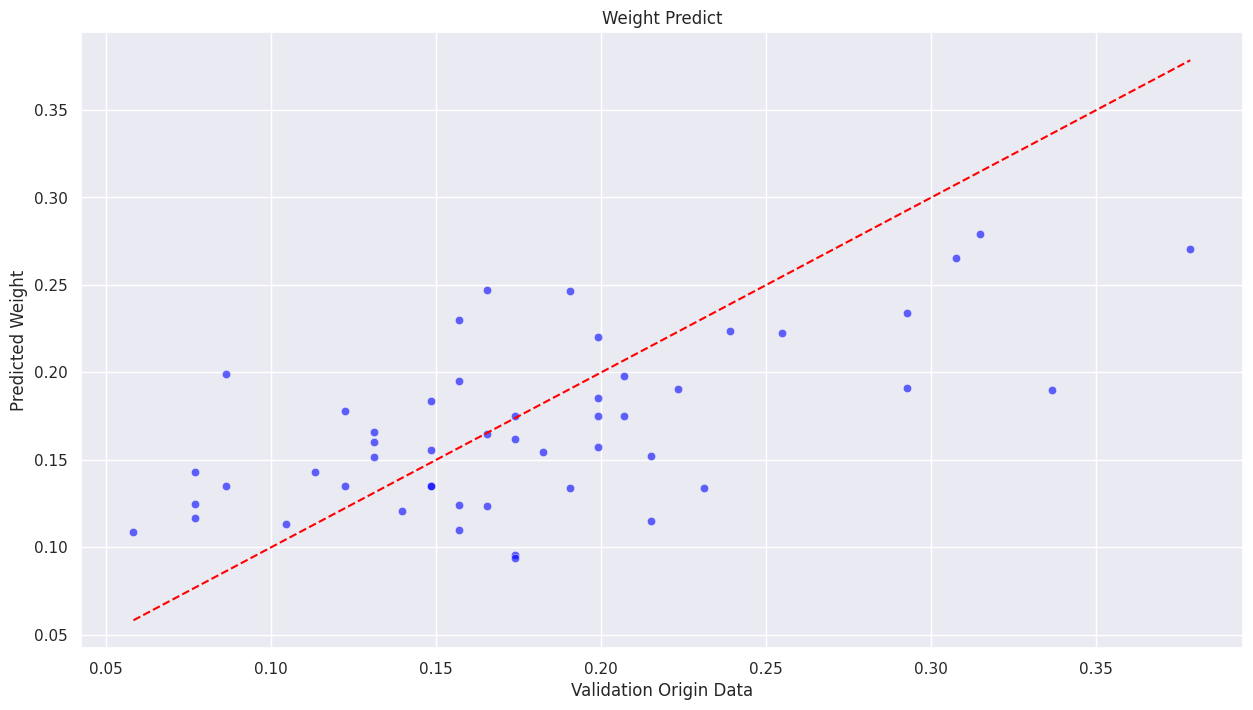

In [18]:
# modeling
#
params = {
    'random_state' : 2024,
    # CART 관련
    'min_samples_leaf' : 3, # leaf노드의 최소 샘플 수
    'max_depth' : 5, # 트리의 최대 깊이
    'max_features' : 0.5, # feature sampling 비율
    'criterion' : 'absolute_error', # 분할 척도
    # Tree Ensemble 관련
    'n_estimators' : 100, # 앙상블 트리 수
    'n_jobs' : -1, # 계산 cpu 수
}

model = ExtraTreesRegressor(**params)
model.fit(x_train, y_train)
pred_val = model.predict(x_val)
# 앙상블을 위한 모델 저장
models.append(model)

val_mae = mean_absolute_error(y_val, pred_val)
print(f'Human Search Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Human Search Validation MAPE : {val_mape * 100 : .4f}%')
origin_test_scatter(y_val, pred_val)

## Human Search Test Data

Human Search CV MAE :  0.0453
Human Search CV MAPE :  27.8819%


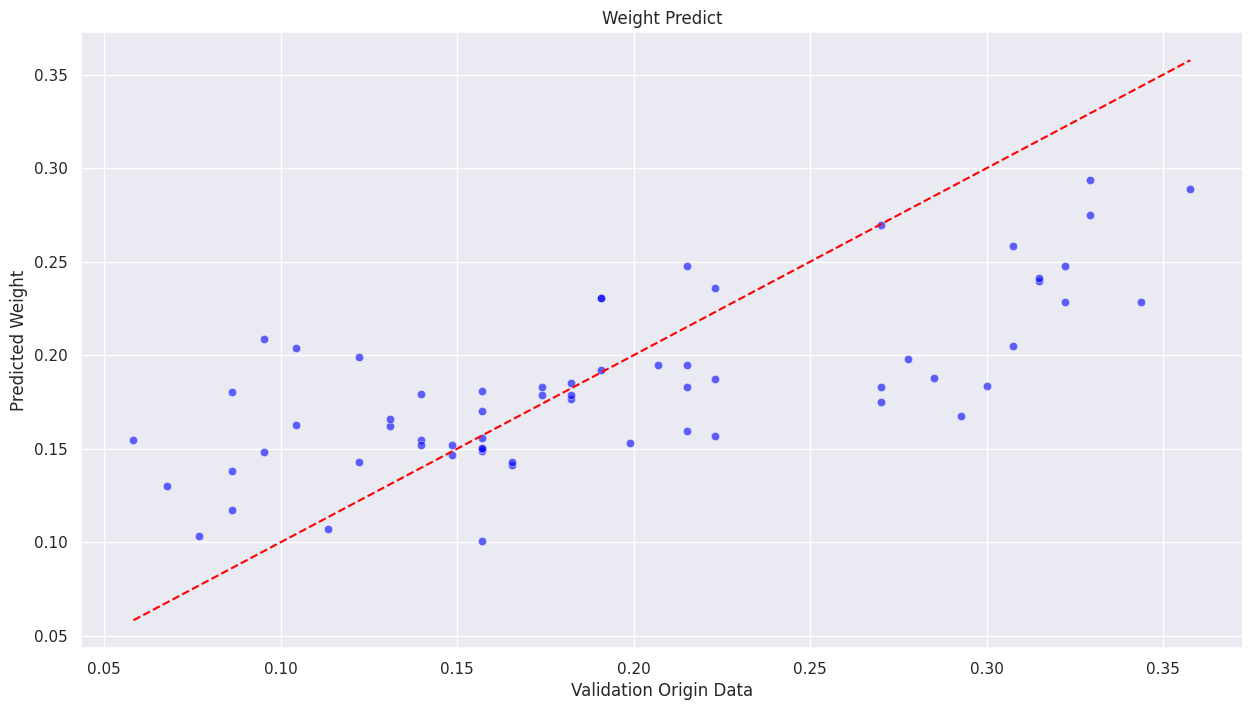

In [19]:
# pred = grid_cv.predict(test)
pred = model.predict(test)
test_mae = mean_absolute_error(answer, pred)
print(f'Human Search CV MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Human Search CV MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Human Search Test Data Ensemble

In [28]:
# a = np.array([1, 2, 3])
# b = np.array([3, 4, 5])
# print(np.mean([a, b], axis = 0))

[2. 3. 4.]


----- test preds check -----
[0.26187857 0.19062082 0.22869553 0.15112441 0.19289886]
[0.24778989 0.19458553 0.22861499 0.14898751 0.18311875]
[0.25483423 0.19260317 0.22865526 0.15005596 0.1880088 ]
----------------------------
Human Search CV MAE :  0.0457
Human Search CV MAPE :  28.4587%


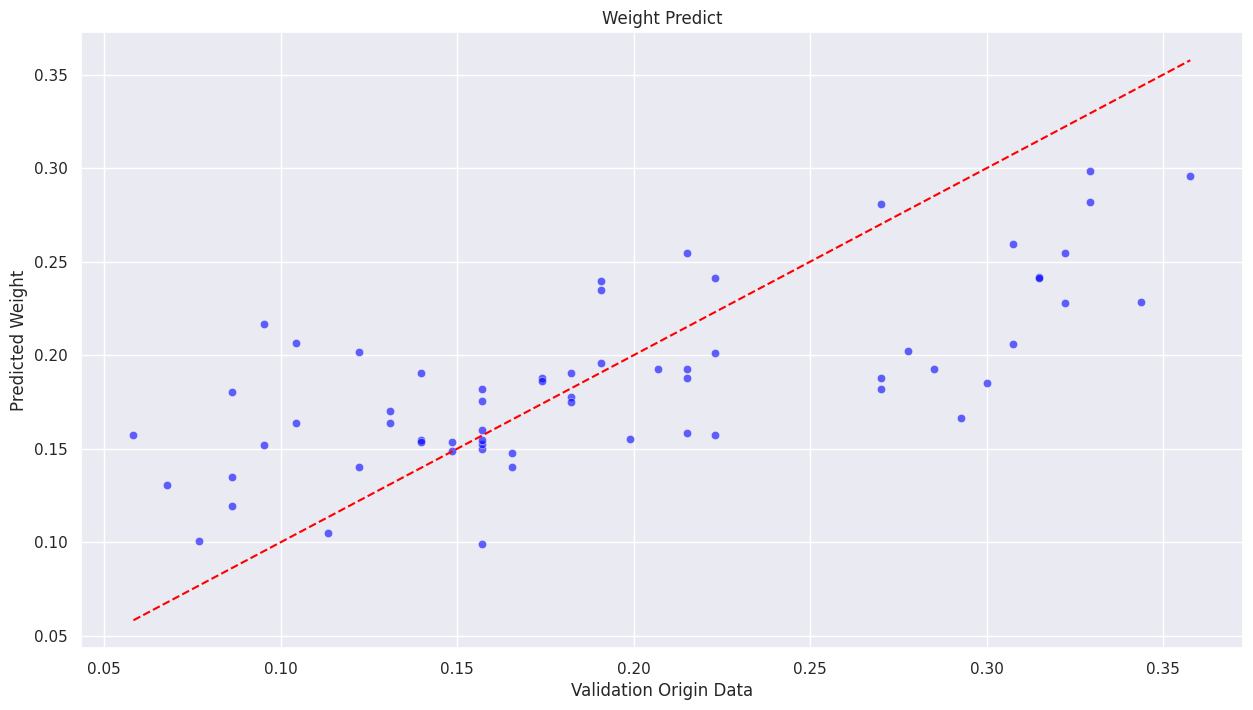

In [31]:
# preds = []

# for model in models:
#     pred = model.predict(test)
#     preds.append(pred)

# pred = np.mean([preds[0], preds[1]], axis = 0)
# print('----- test preds check -----')
# print(preds[0][:5])
# print(preds[1][:5])
# print(pred[:5])
# print('----------------------------')
# test_mae = mean_absolute_error(answer, pred)
# print(f'Human Search CV MAE : {test_mae : .4f}')
# test_mape = mean_absolute_percentage_error(answer, pred)
# print(f'Human Search CV MAPE : {test_mape * 100 : .4f}%')
# origin_test_scatter(answer, pred)

## Pycaret

In [37]:
# pip install pycaret

  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyod-2.0.2-py3-none-any.whl
  Using cached category_encoders-2.6.4-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached matplotlib-3.7.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
  Using cached schemdraw-0.15-py3-none-any.whl.metadata (2.2 kB)
  Using cached plotly_resampler-0.10.0-py3-non

In [49]:
##### get data
data_for_model = data_filtered

##### train, test split from "total data"
train, test = train_test_split(data_for_model, test_size = 0.2, random_state = 2024)
print('train-test shape : ', train.shape, test.shape)

##### get targets from train, test
target = train.pop('weight')
answer = test.pop('weight')
x_cols = train.columns

##### split train, validation
# x_train, x_val, y_train, y_val = train_test_split(train, target, test_size = 0.2, random_state = 2024)
# print('train-valid shape : ', x_train.shape, y_train.shape, x_val.shape, y_val.shape)
# print('test shape : ', test.shape, answer.shape)


##### 로그변환
target = np.log1p(target)
# y_val = np.log1p(y_val)
answer = np.log1p(answer)

##### Data scaling
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
train = scaler.fit_transform(train) # numpy array
# x_val = scaler.transform(x_val)
test = scaler.transform(test)

train = pd.concat([pd.DataFrame(train, columns=x_cols).reset_index(drop=True), pd.DataFrame(target).reset_index(drop=True)], axis=1)
# valid = pd.concat([pd.DataFrame(x_val, columns=x_cols).reset_index(drop=True), pd.DataFrame(y_val).reset_index(drop=True)], axis=1)
test = pd.DataFrame(test, columns=x_cols)

print('train-test shape : ', train.shape, test.shape, answer.shape)
display(train.head(5))
# display(valid.head(5))
display(test.head(5))

train-test shape :  (249, 6) (63, 6)
train-test shape :  (249, 6) (63, 5) (63,)


,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2,weight
0,-1.363548,-1.087201,-1.071581,1.531739,-1.362956,0.157004
1,1.322555,1.171878,1.181571,-0.903047,0.872951,0.157004
2,0.248114,0.669861,0.565037,0.456901,-0.564974,0.139762
3,-0.826327,-0.585183,-0.634402,0.907273,-0.926994,0.086178
4,1.322555,0.732613,0.710763,-1.521205,1.778979,0.314811


,leaf_2,leaf_length_sum,leaf_area,leaf_div_1,leaf_div_2
0,1.322555,1.799401,1.854154,-0.019964,-0.127994
1,0.677891,0.795365,0.744392,-0.265265,0.122242
2,1.322555,1.046374,1.047055,-1.079664,1.111271
3,-0.718883,-0.020413,-0.202828,1.756972,-1.504293
4,0.248114,-0.083166,-0.107546,-0.814739,0.759207


In [47]:
from pycaret.regression import *
s = setup(train, target = 'weight', session_id = 2024) # init training environment, session_id -> random seed
best = compare_models(sort='MAPE', n_select=5)

,Description,Value
0,Session id,2024
1,Target,weight
2,Target type,Regression
3,Original data shape,"(249, 6)"
4,Transformed data shape,"(249, 6)"
5,Transformed train set shape,"(174, 6)"
6,Transformed test set shape,"(75, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0509,0.0041,0.0634,0.2886,0.0529,0.3317,0.0340
omp,Orthogonal Matching Pursuit,0.0506,0.0040,0.0624,0.3161,0.0522,0.3530,0.0190
ridge,Ridge Regression,0.0511,0.0040,0.0625,0.3112,0.0523,0.3548,0.0220
lr,Linear Regression,0.0515,0.0041,0.0630,0.2994,0.0527,0.3550,0.0220
br,Bayesian Ridge,0.0510,0.0040,0.0625,0.3115,0.0523,0.3579,0.0280
lightgbm,Light Gradient Boosting Machine,0.0566,0.0050,0.0694,0.1241,0.0580,0.3791,0.0560
knn,K Neighbors Regressor,0.0560,0.0049,0.0690,0.1408,0.0578,0.3803,0.0250
rf,Random Forest Regressor,0.0599,0.0055,0.0727,0.0041,0.0608,0.4047,0.3320
gbr,Gradient Boosting Regressor,0.0599,0.0056,0.0737,-0.0141,0.0618,0.4157,0.0820
ada,AdaBoost Regressor,0.0574,0.0049,0.0692,0.1510,0.0581,0.4198,0.0640


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [50]:
# 모델 튜닝
tuned_models = [tune_model(model) for model in best]
# 모델 블렌딩
blender = blend_models(tuned_models)
# 예측
prediction = predict_model(blender, data=test)

# 예측 결과 출력
print(prediction)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0603,0.0067,0.0818,0.2893,0.0664,0.3190
1,0.0575,0.0057,0.0756,-0.1612,0.0647,0.4269
2,0.0512,0.0035,0.0592,0.4105,0.0485,0.2539
3,0.0586,0.0051,0.0717,0.2491,0.0594,0.3640
4,0.0500,0.0037,0.0609,-0.1052,0.0506,0.2823
5,0.0498,0.0035,0.0592,0.4459,0.0500,0.3758
6,0.0422,0.0025,0.0498,0.6054,0.0415,0.2781
7,0.0476,0.0036,0.0601,0.3448,0.0497,0.2495
8,0.0536,0.0039,0.0627,0.3695,0.0536,0.5056


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0588,0.0066,0.0810,0.3039,0.0656,0.3163
1,0.0581,0.0055,0.0743,-0.1210,0.0634,0.4526
2,0.0484,0.0032,0.0570,0.4539,0.0468,0.2540
3,0.0558,0.0047,0.0687,0.3094,0.0568,0.3542
4,0.0482,0.0034,0.0580,-0.0029,0.0482,0.2820
5,0.0502,0.0036,0.0604,0.4231,0.0514,0.4017
6,0.0410,0.0023,0.0484,0.6270,0.0404,0.2751
7,0.0476,0.0034,0.0587,0.3755,0.0486,0.2603
8,0.0558,0.0042,0.0649,0.3259,0.0556,0.5428


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0585,0.0064,0.0797,0.3246,0.0645,0.3147
1,0.0566,0.0054,0.0736,-0.1000,0.0629,0.4386
2,0.0481,0.0031,0.0561,0.4708,0.0460,0.2537
3,0.0559,0.0046,0.0681,0.3228,0.0563,0.3547
4,0.0505,0.0036,0.0604,-0.0870,0.0503,0.2936
5,0.0532,0.0038,0.0618,0.3960,0.0525,0.4183
6,0.0418,0.0024,0.0490,0.6172,0.0409,0.2781
7,0.0481,0.0035,0.0588,0.3729,0.0488,0.2668
8,0.0558,0.0044,0.0660,0.3034,0.0565,0.5490


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0609,0.0066,0.0813,0.2987,0.0659,0.3289
1,0.0576,0.0057,0.0753,-0.1518,0.0644,0.4341
2,0.0494,0.0032,0.0564,0.4650,0.0462,0.2580
3,0.0593,0.0052,0.0718,0.2465,0.0595,0.3772
4,0.0503,0.0037,0.0610,-0.1083,0.0507,0.2896
5,0.0521,0.0037,0.0608,0.4165,0.0515,0.4045
6,0.0432,0.0026,0.0509,0.5880,0.0424,0.2880
7,0.0465,0.0034,0.0585,0.3798,0.0484,0.2558
8,0.0555,0.0042,0.0650,0.3232,0.0557,0.5397


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0585,0.0064,0.0798,0.3241,0.0645,0.3148
1,0.0566,0.0054,0.0736,-0.1001,0.0629,0.4386
2,0.0481,0.0031,0.0561,0.4709,0.0460,0.2537
3,0.0559,0.0046,0.0681,0.3228,0.0563,0.3546
4,0.0505,0.0036,0.0604,-0.0867,0.0503,0.2936
5,0.0531,0.0038,0.0618,0.3959,0.0525,0.4185
6,0.0418,0.0024,0.0490,0.6174,0.0409,0.2780
7,0.0481,0.0035,0.0588,0.3728,0.0488,0.2670
8,0.0558,0.0044,0.0660,0.3031,0.0565,0.5493


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0593,0.0065,0.0806,0.3101,0.0653,0.3184
1,0.0570,0.0055,0.0741,-0.1158,0.0634,0.4367
2,0.0490,0.0032,0.0568,0.4570,0.0466,0.2546
3,0.0570,0.0048,0.0692,0.2991,0.0573,0.3607
4,0.0499,0.0036,0.0600,-0.0733,0.0499,0.2882
5,0.0517,0.0037,0.0606,0.4185,0.0515,0.4037
6,0.0420,0.0024,0.0493,0.6138,0.0411,0.2795
7,0.0474,0.0035,0.0588,0.3719,0.0488,0.2588
8,0.0553,0.0042,0.0648,0.3274,0.0555,0.5373


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

      leaf_2  leaf_length_sum  leaf_area  leaf_div_1  leaf_div_2  \
0   1.322555         1.799401   1.854154   -0.019964   -0.127994   
1   0.677891         0.795365   0.744392   -0.265265    0.122242   
2   1.322555         1.046374   1.047055   -1.079664    1.111272   
3  -0.718883        -0.020413  -0.202828    1.756972   -1.504293   
4   0.248114        -0.083166  -0.107546   -0.814739    0.759207   
..       ...              ...        ...         ...         ...   
58  1.322555         0.983622   0.979796   -1.167972    1.236197   
59 -0.611439         0.356100   0.105439    2.187744   -1.754530   
60 -0.289107        -0.271422  -0.314925    0.068345   -0.213601   
61 -0.181663        -0.522431  -0.508853   -0.653480    0.560156   
62 -0.826328        -1.463714  -1.262146   -0.947201    0.931146   

    prediction_label  
0           0.241359  
1           0.208842  
2           0.242823  
3           0.145160  
4           0.193992  
..               ...  
58          0.243884  

Human Search CV MAE :  0.0439
Human Search CV MAPE :  29.0533%


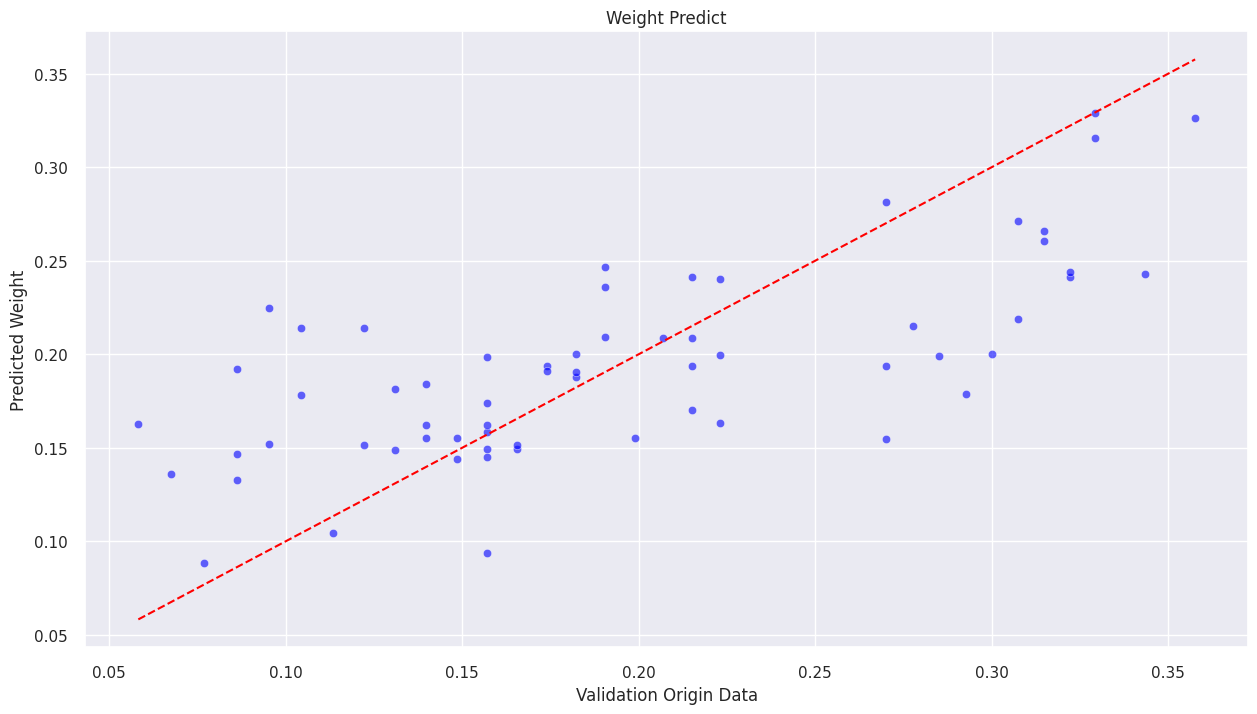

In [62]:
pred = prediction.prediction_label.values
test_mae = mean_absolute_error(answer, pred)
print(f'Human Search CV MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Human Search CV MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Grid Search Modeling

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.051 total time=   0.5s
[CV 2/3] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.054 total time=   0.5s
[CV 3/3] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=100;, score=-0.045 total time=   0.4s
[CV 1/3] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=200;, score=-0.051 total time=   0.7s
[CV 2/3] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=200;, score=-0.053 total time=   0.7s
[CV 3/3] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=3, n_estimators=200;, score=-0.044 total time=   0.7s
[CV 1/3] END criterion=absolute_error, max_depth=5, max_features=0.5, min_samples_leaf=5, n_e

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


최적 하이퍼 파라미터:
 {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 5, 'n_estimators': 200}
최고 예측 정확도: 0.0492
Grid Search CV Validation MAE :  0.0460
Grid Search Validation MAPE :  28.7703%


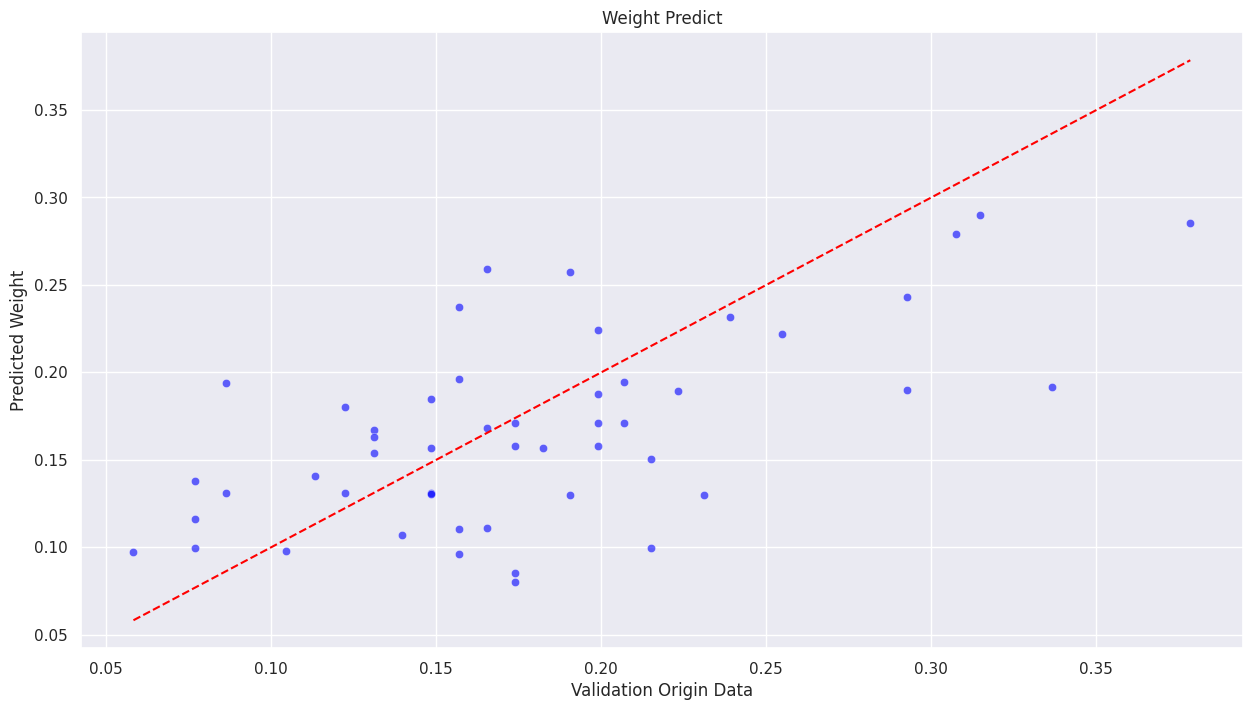

In [22]:
params = {
    # CART 관련
    'min_samples_leaf' : [3, 5],
    'max_depth' : [5, 8, 10],
    'max_features' : [0.5, 0.8], # featrue sampling 비율
    'criterion' : ['absolute_error'], # 분할 척도
    # Tree Ensembole 관련
    'n_estimators':[100, 200], # 앙상블 트리 수
}

# model = RandomForestRegressor(random_state=2024, n_jobs=-1)
model = ExtraTreesRegressor(random_state=2024, n_jobs=-1)
grid_cv = GridSearchCV(model , param_grid=params , cv=3, verbose=3, scoring='neg_mean_absolute_error') # cv:cv-fold 분발 수
grid_cv.fit(x_train , y_train) # grid search start

# GridSearchCV의 regit 파라미터가 기본 설정 되어있기 때문에, 최적 파라미터로 모든 데이터를 새로 학습한 모델이 gird_cv에 적용됨
pred_val = grid_cv.predict(x_val)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(-grid_cv.best_score_))
val_mae = mean_absolute_error(y_val, pred_val)
print(f'Grid Search CV Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Grid Search Validation MAPE : {val_mape * 100 : .4f}%')
origin_test_scatter(y_val, pred_val)

## Grid CV Test Data

Grid Search CV MAE :  0.0455
Grid Search CV MAPE :  28.2700%


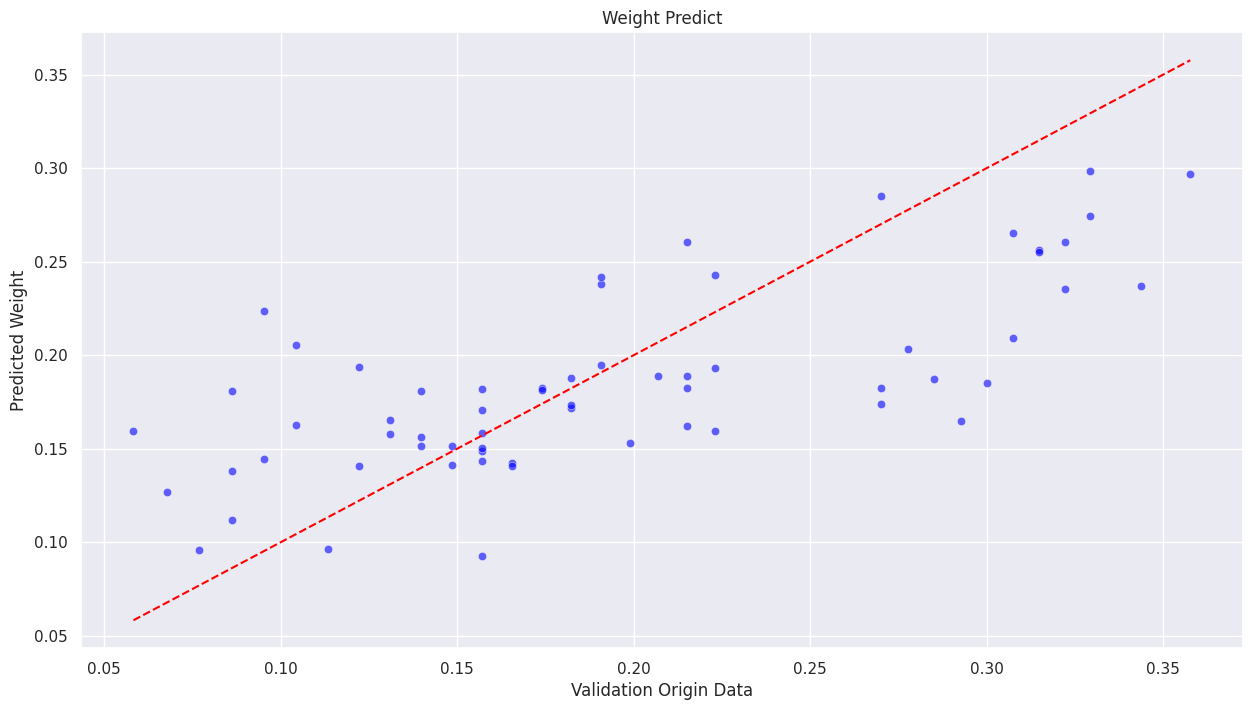

In [23]:
pred = grid_cv.predict(test)
test_mae = mean_absolute_error(answer, pred)
print(f'Grid Search CV MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Grid Search CV MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

## Human Searching after Grid Searh CV

Grid Search 결과

* 최적 하이퍼 파라미터:
 {'criterion': 'absolute_error', 'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 8, 'n_estimators': 150}
* 최고 예측 정확도: 0.0569
* Grid Search CV Validation MAE :  0.0575
* Grid Search Validation MAPE :  31.3919%
* Grid Search CV MAE :  0.0540
* Grid Search CV MAPE :  26.6781%

In [ ]:
# modeling

params = {
    'random_state' : 2024,
    'criterion': 'absolute_error',
    'max_depth': 6,
    'max_features': 0.8,
    # 'min_samples_split': 20,
    'min_samples_leaf': 8,
    'n_estimators': 50,
    'n_jobs' : -1,
}

# {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 5, 'n_estimators': 100}

model = RandomForestRegressor(**params)
model.fit(x_train, y_train)
pred_val = model.predict(x_val)

val_mae = mean_absolute_error(y_val, pred_val)
print(f'Validation MAE : {val_mae : .4f}')
val_mape = mean_absolute_percentage_error(y_val, pred_val)
print(f'Validation MAPE : {val_mape * 100 : .4f}%')

pred = model.predict(test)
test_mae = mean_absolute_error(answer, pred)
print(f'Test MAE : {test_mae : .4f}')
test_mape = mean_absolute_percentage_error(answer, pred)
print(f'Test MAPE : {test_mape * 100 : .4f}%')
origin_test_scatter(answer, pred)

Validation MAE :  0.0418
Validation MAPE :  22.5238%
Test MAE :  0.0569
Test MAPE :  28.9585%


Validation MAE :  0.0418  
Validation MAPE :  22.5238%  
Test MAE :  0.0569  
Test MAPE :  28.9585%  